# Regions and Resuspension Signal

In [1]:
import cmocean.cm as cm
import copy
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import matplotlib.gridspec as gridspec
import pandas as pd
from matplotlib.colors import LogNorm
from matplotlib.colors import ListedColormap
#

In [3]:
#filename = '/home/vvalenzuela/MOAD/Ocean_Parcels/results/Simulations_runs/PBDE_particles_for_0112022_run_365_days_full_kernels_tau_0_01_ratio_0_2_sv_5_AD_0_052.zarr'
filename = '/home/vvalenzuela/MOAD/Ocean_Parcels/results/Simulations_runs/PBDE_particles_for_0112022_run_365_days_full_release_run_tau_0_01_ratio_0_2_sv_5_AD_0_052.zarr'

In [ ]:
import Regions_functions_V2
from Regions_functions_V2 import plot_vertical_concentration_state_profiles, plot_vertical_total_state_profiles, plot_vertical_state_status, interpolate_volume_profile
polygon_dict = Regions_functions_V2.polygon_definition(filename)

In [ ]:
regions_water, regions_sedimented = Regions_functions_V2.status_states_regions_map(polygon_dict)
####### regions ########
# written like N1_sedimented_lon, N1_sedimented_lat 
#
region_names = ['N1', 'N2', 'N3', 'C1', 'S1', 'SP', 'HW1', 'F1', 'S2', 'H1', 'J1']

water_regions_lon = [regions_water[region]['lon'] for region in region_names]
water_regions_lat = [regions_water[region]['lat'] for region in region_names]
water_regions_depth = [regions_water[region]['depth'] for region in region_names]

sedimented_regions_lon = [regions_sedimented[region]['lon'] for region in region_names]
sedimented_regions_lat = [regions_sedimented[region]['lat'] for region in region_names]
sedimented_regions_depth = [regions_sedimented[region]['depth'] for region in region_names]

In [4]:
data = xr.open_dataset(filename, engine='zarr')

Lets see for 1 day cycle    :o

In [ ]:
times_day = data.isel(obs = np.arange(1216, 1460)).time[0,:].values
data_day =  data.isel(obs = np.arange(1216, 1460))

In [ ]:
data_day_water = data_day.where((data_day.status < 10) & (data_day.status > 0))
data_day_sediment = data_day.where(data_day.status > 10)

In [ ]:
begin = pd.to_datetime(times_day[0]).to_pydatetime()
end = pd.to_datetime(times_day[-1]).to_pydatetime()
t_len = (end - begin).days

In [ ]:
import os; import glob; from datetime import timedelta
def date_files(date, path, prefix_type= 'grid_T.nc'):
    folder = date.strftime("%d%b%y").lower()
    prefix = os.path.join(path, folder + f'/SalishSea_1h_{date.strftime("%Y%m%d").lower()}_{date.strftime("%Y%m%d").lower()}_{prefix_type}*')
    file_name = glob.glob(prefix) 
    return file_name
#
def get_timestamps(start,length):
    timestamps=[]
    duration = timedelta(days=length)
    for day in range(duration.days):
        timestamps.append([start + timedelta(days=day)])
    return timestamps
#
dates = get_timestamps(begin,t_len)
hourly_dates = pd.date_range(start=begin, end=end, freq='H')[:-1]
#
path_days_h = '/results2/SalishSea/nowcast-green.202111/'
#
files_U = []
files_V = []
files_e3t = []
for i in range(t_len):
    files_U.append(date_files(dates[i][0],path_days_h, prefix_type = 'grid_U.nc'))
    files_V.append(date_files(dates[i][0],path_days_h, prefix_type = 'grid_V.nc'))
    files_e3t.append(date_files(dates[i][0],path_days_h, prefix_type = 'grid_T.nc'))
#
path_bat = '/ocean/vvalenzuela/MOAD/grid2/mesh_mask202108_TDV.nc'
bat_file = xr.open_dataset(path_bat)
mbathy = bat_file['mbathy'][0]
#     

In [ ]:
jjii = xr.open_dataset('/ocean/vvalenzuela/MOAD/grid/grid_from_lat_lon_mask999.nc')
def finder(lati,loni):
    j = [jjii.jj.sel(lats=lati, lons=loni, method='nearest').item()][0]
    i = [jjii.ii.sel(lats=lati, lons=loni, method='nearest').item()][0]
    return j,i
#################################################################################################    
a, b = finder(49.2,-123.5)

In [ ]:
filepaths_U = [f[0] for f in files_U]
filepaths_V = [f[0] for f in files_V]
filepaths_e3t = [f[0] for f in files_e3t]

In [ ]:
depth_idx = mbathy[a,b].values

In [ ]:
U_vels = []
for file in filepaths_U:
    datito_u = xr.open_dataset(file)['vozocrtx'].isel(depthu=depth_idx - 1, y=a, x=b)
    U_vels.append(datito_u)
#
V_vels = []
for file in filepaths_V:
    datito_v = xr.open_dataset(file)['vomecrty'].isel(depthv=depth_idx - 1, y=a, x=b)
    V_vels.append(datito_v)
#
e3ts = []
for file in filepaths_e3t:
    datito_e3t = xr.open_dataset(file)['e3t'].isel(deptht=depth_idx - 1, y=a, x=b)
    e3ts.append(datito_e3t)  
#
sshs = []
for file in filepaths_e3t:
    datito_ssh = xr.open_dataset(file)['sossheig'].isel(y=a, x=b)
    sshs.append(datito_ssh)           

In [ ]:
from Calculations_Functions import proportions_from_filename

In [ ]:
proportions = proportions_from_filename(filename = filename)
#
water, sediment =  proportions['Sewage Water'] + proportions['Colloidal Water'] + proportions['Marine Water'] , proportions['Sewage Sediment'] + proportions['Colloidal Sediment'] + proportions['Marine Sediment']

In [ ]:
U_velocity = xr.concat(U_vels, dim='time_counter')
V_velocity = xr.concat(V_vels, dim='time_counter')


In [ ]:
e3t_values = xr.concat(e3ts, dim='time_counter')
ssh_values = xr.concat(sshs, dim='time_counter')

$$u^{*} = \frac{U \cdot k}{ln(\frac{z}{z_{*}})}$$


In [ ]:
z = e3t_values / 2
z_star = 0.07
k = 0.42
#
vel_horizontal = np.sqrt(U_velocity**2 + V_velocity**2)
# Final u* calculation
with np.errstate(divide='ignore', invalid='ignore'):
    u_star = (vel_horizontal * k) / np.log(z / z_star)

In [ ]:
from scipy.interpolate import UnivariateSpline
#
spline_ustar = UnivariateSpline(range(len(u_star)), u_star.values, s=.006)
smoothed_values_ustar = spline_ustar(range(len(u_star)))
#
smoothed_ustar = pd.Series(smoothed_values_ustar, index=U_velocity.time_counter)
#
spline_ssh = UnivariateSpline(range(len(ssh_values)), ssh_values.values, s=700)
smoothed_values_ssh = spline_ssh(range(len(ssh_values)))
#
smoothed_ssh = pd.Series(smoothed_values_ssh, index=ssh_values.time_counter)
#
plt.rcParams.update({'font.size': 18})
#
fig, ax = plt.subplots(2,1,figsize = (18,8), height_ratios=[1, .5], sharex=True)
#
ax[1].plot(smoothed_ssh.index, ssh_values, 'g', alpha = .2)
ax[1].plot(smoothed_ssh, 'g')
#
ax[1].grid(alpha = .7)
ax[1].set_ylabel('SSH [m]')
#
ax[0].plot(smoothed_ustar.index, u_star, 'k', alpha = .2, label = r'Raw $\tau$')
ax[0].plot(smoothed_ustar, 'k', alpha = 1, label = r'Smoothed $\tau$')
#
#ax.vlines(x = times_day[t], ymin = 0, ymax = .015, color = 'g')
#ax.hlines(y=0.01, xmin = U_velocity['time_counter'][0], xmax = U_velocity['time_counter'][-1], color = 'g', linestyle = '--')
ax[0].set_ylabel(r'Bottom Stress due to Currents ($\tau$)')
ax[0].legend(loc = 'upper left')
ax[0].grid(alpha = .7)
#
axis = ax[0].twinx()
axis.plot(water, 'b', label = 'Water Column')
axis.plot(sediment, 'r', label = 'Sediment')
axis.set_xlim([times_day[0], times_day[-1]])
axis.legend(loc = 'upper right')
axis.set_ylabel('Proportion (%)')
#
ax[0].set_ylim([-0.001, 0.016])
axis.set_ylim([-5, 80])
#
plt.subplots_adjust(hspace=0, top=0.97, bottom=0.07, left=0.07, right=0.93)
#
#
plt.tight_layout()

Can we know when resuspension happens in the data? 

# In Sediment Transitions

In [5]:
labels_sediment = ['S. S. to C.', 'C. S. to M. ', 'M. S. to C.']

status = data.status.values
#
status_now = status[:, :-1]     # current timestep
status_next = status[:, 1:]     # next timestep
#
sediment_s_to_c = (status_now == 11) & (status_next == 12)
sediment_c_to_m = (status_now == 12) & (status_next == 13)
sediment_m_to_c = (status_now == 13) & (status_next == 12)

total_sediment_transitions = (
    np.count_nonzero(sediment_s_to_c) +
    np.count_nonzero(sediment_c_to_m) +
    np.count_nonzero(sediment_m_to_c)
)
#### Depths 
#
z = data.z.values  
z_now = z[:, :-1] 
#
depths_sediment_s_to_c = z_now[sediment_s_to_c]
depths_sediment_c_to_m = z_now[sediment_c_to_m]
depths_sediment_m_to_c = z_now[sediment_m_to_c]
#
depth_data_sediment = [
    depths_sediment_s_to_c, depths_sediment_c_to_m, depths_sediment_m_to_c
]
means_sediment = []
medians_sediment = []
mins_sediment = []
maxs_sediment = []
counts = []

for label, arr in zip(labels_sediment, depth_data_sediment):
    if arr.size > 0:
        means_sediment.append(arr.mean())
        medians_sediment.append(np.median(arr))
        mins_sediment.append(arr.min())
        maxs_sediment.append(arr.max())
        counts.append(arr.size)
        print(f'{label}: mean={arr.mean():.2f}, median={np.median(arr):.2f}, min={arr.min():.2f}, max={arr.max():.2f}, n={arr.size}')

#
#
# Percentage of sediment transitions
print(np.count_nonzero(sediment_s_to_c) / total_sediment_transitions * 100, '% sediment s_to_c')
print(np.count_nonzero(sediment_c_to_m) / total_sediment_transitions * 100, '% sediment c_to_m')
print(np.count_nonzero(sediment_m_to_c) / total_sediment_transitions * 100, '% sediment m_to_c')
#
percentage_sediment = [np.count_nonzero(sediment_s_to_c) / total_sediment_transitions * 100, 
           np.count_nonzero(sediment_c_to_m) / total_sediment_transitions * 100,
           np.count_nonzero(sediment_m_to_c) / total_sediment_transitions * 100]

S. S. to C.: mean=83.69, median=83.88, min=52.47, max=110.30, n=9766
C. S. to M. : mean=190.98, median=198.68, min=0.00, max=428.00, n=102619
M. S. to C.: mean=208.99, median=212.30, min=0.00, max=428.00, n=129783
4.032737603647055 % sediment s_to_c
42.375128010306895 % sediment c_to_m
53.592134386046055 % sediment m_to_c


# Sediment to Water Column Transitions

In [6]:
status = data.status.values
#
status_now = status[:, :-1]     # current timestep
status_next = status[:, 1:]     # next timestep
#
all_ss_to_c = (status_now == 11) & (status_next == 2)
all_cs_to_c = (status_now == 12) & (status_next == 2)
all_ms_to_c = (status_now == 13) & (status_next == 2)

#all_ss_to_m = (status_now == 11) & (status_next == 3)
all_cs_to_m = (status_now == 12) & (status_next == 3)
all_ms_to_m = (status_now == 13) & (status_next == 3)

total_resuspension_transitions = (
    np.count_nonzero(all_ss_to_c) +
    np.count_nonzero(all_cs_to_c) +
    np.count_nonzero(all_ms_to_c) +
    #np.count_nonzero(all_ss_to_m) +
    np.count_nonzero(all_cs_to_m) +
    np.count_nonzero(all_ms_to_m)
)

# Percentage of sediment transitions
print(np.count_nonzero(all_ss_to_c) / total_resuspension_transitions * 100, '% ss_to_c')
print(np.count_nonzero(all_cs_to_c) / total_resuspension_transitions * 100, '% cs_to_c')
print(np.count_nonzero(all_ms_to_c) / total_resuspension_transitions * 100, '% ms_to_c')
#print(np.count_nonzero(all_ss_to_m) / total_resuspension_transitions * 100, '% ss_to_m')
print(np.count_nonzero(all_cs_to_m) / total_resuspension_transitions * 100, '% cs_to_m')
print(np.count_nonzero(all_ms_to_m) / total_resuspension_transitions * 100, '% ms_to_m')


1.6271785737260185 % ss_to_c
41.85456876606826 % cs_to_c
4.1445306347893025 % ms_to_c
0.6421759894944888 % cs_to_m
51.73154603592193 % ms_to_m


In [7]:
labels_res = ['S. S. to C.', 'C. S. to C.', 'M. S. to C.'
              #, 'S. S. to M.'
              , 'C. S. to M.', 'M. S to M.']
per_res = [np.count_nonzero(all_ss_to_c) / total_resuspension_transitions * 100, 
           np.count_nonzero(all_cs_to_c) / total_resuspension_transitions * 100,
           np.count_nonzero(all_ms_to_c) / total_resuspension_transitions * 100,
           #np.count_nonzero(all_ss_to_m) / total_resuspension_transitions * 100,
           np.count_nonzero(all_cs_to_m) / total_resuspension_transitions * 100,
           np.count_nonzero(all_ms_to_m) / total_resuspension_transitions * 100]
colors_res = ['k', 'r', 'g'
              #, 'k'
              , 'r', 'g']

In [ ]:
z = data.z.values  

z_now = z[:, :-1] 


depths_ss_to_c = z_now[all_ss_to_c]
depths_cs_to_c = z_now[all_cs_to_c]
depths_ms_to_c = z_now[all_ms_to_c]

#depths_ss_to_m = z_now[all_ss_to_m]
depths_cs_to_m = z_now[all_cs_to_m]
depths_ms_to_m = z_now[all_ms_to_m]

#
depth_data = [
    depths_ss_to_c, depths_cs_to_c, depths_ms_to_c
    #,depths_ss_to_m
    , depths_cs_to_m, depths_ms_to_m
]
means = []
medians = []
mins = []
maxs = []
counts = []

for label, arr in zip(labels_res, depth_data):
    if arr.size > 0:
        means.append(arr.mean())
        medians.append(np.median(arr))
        mins.append(arr.min())
        maxs.append(arr.max())
        counts.append(arr.size)
        print(f'{label}: mean={arr.mean():.2f}, median={np.median(arr):.2f}, min={arr.min():.2f}, max={arr.max():.2f}, n={arr.size}')
    else:
        means.append(np.nan)
        medians.append(np.nan)
        mins.append(np.nan)
        maxs.append(np.nan)
        counts.append(0)
        print(f'{label}: No transitions')
#


S. S. to C.: mean=85.18, median=85.47, min=55.13, max=118.20, n=14671
C. S. to C.: mean=248.66, median=262.08, min=0.00, max=428.00, n=377370
M. S. to C.: mean=278.81, median=301.59, min=1.20, max=428.00, n=37368
C. S. to M.: mean=252.16, median=272.16, min=1.59, max=428.00, n=5790
M. S to M.: mean=280.30, median=303.40, min=0.00, max=428.00, n=466423


# Water Column Transitions

In [9]:
labels_water = ['S. W.C. to C.', 'C. W.C. to M. ', 'M. W.C. to C.']

status = data.status.values
#
status_now = status[:, :-1]     # current timestep
status_next = status[:, 1:]     # next timestep
#
water_s_to_c = (status_now == 1) & (status_next == 2)
water_c_to_m = (status_now == 2) & (status_next == 3)
water_m_to_c = (status_now == 3) & (status_next == 2)

total_water_transitions = (
    np.count_nonzero(water_s_to_c) +
    np.count_nonzero(water_c_to_m) +
    np.count_nonzero(water_m_to_c)
)
#### Depths 
#
z = data.z.values  
z_now = z[:, :-1] 
#
depths_water_s_to_c = z_now[water_s_to_c]
depths_water_c_to_m = z_now[water_c_to_m]
depths_water_m_to_c = z_now[water_m_to_c]
#
depth_data_water = [
    depths_water_s_to_c, depths_water_c_to_m, depths_water_m_to_c
]
means_water = []
medians_water = []
mins_water = []
maxs_water = []
counts = []

for label, arr in zip(labels_water, depth_data_water):
    if arr.size > 0:
        means_water.append(arr.mean())
        medians_water.append(np.median(arr))
        mins_water.append(arr.min())
        maxs_water.append(arr.max())
        counts.append(arr.size)
        print(f'{label}: mean={arr.mean():.2f}, median={np.median(arr):.2f}, min={arr.min():.2f}, max={arr.max():.2f}, n={arr.size}')

#
#
# Percentage of water transitions
print(np.count_nonzero(water_s_to_c) / total_water_transitions * 100, '% water s_to_c')
print(np.count_nonzero(water_c_to_m) / total_water_transitions * 100, '% water c_to_m')
print(np.count_nonzero(water_m_to_c) / total_water_transitions * 100, '% water m_to_c')
#
percentage_water = [np.count_nonzero(water_s_to_c) / total_water_transitions * 100, 
           np.count_nonzero(water_c_to_m) / total_water_transitions * 100,
           np.count_nonzero(water_m_to_c) / total_water_transitions * 100]

S. W.C. to C.: mean=77.73, median=77.06, min=64.22, max=98.51, n=217
C. W.C. to M. : mean=200.53, median=201.30, min=0.00, max=427.99, n=178161
M. W.C. to C.: mean=263.76, median=283.75, min=0.00, max=427.99, n=109057
0.07549532937881609 % water s_to_c
61.98305703898272 % water c_to_m
37.94144763163846 % water m_to_c


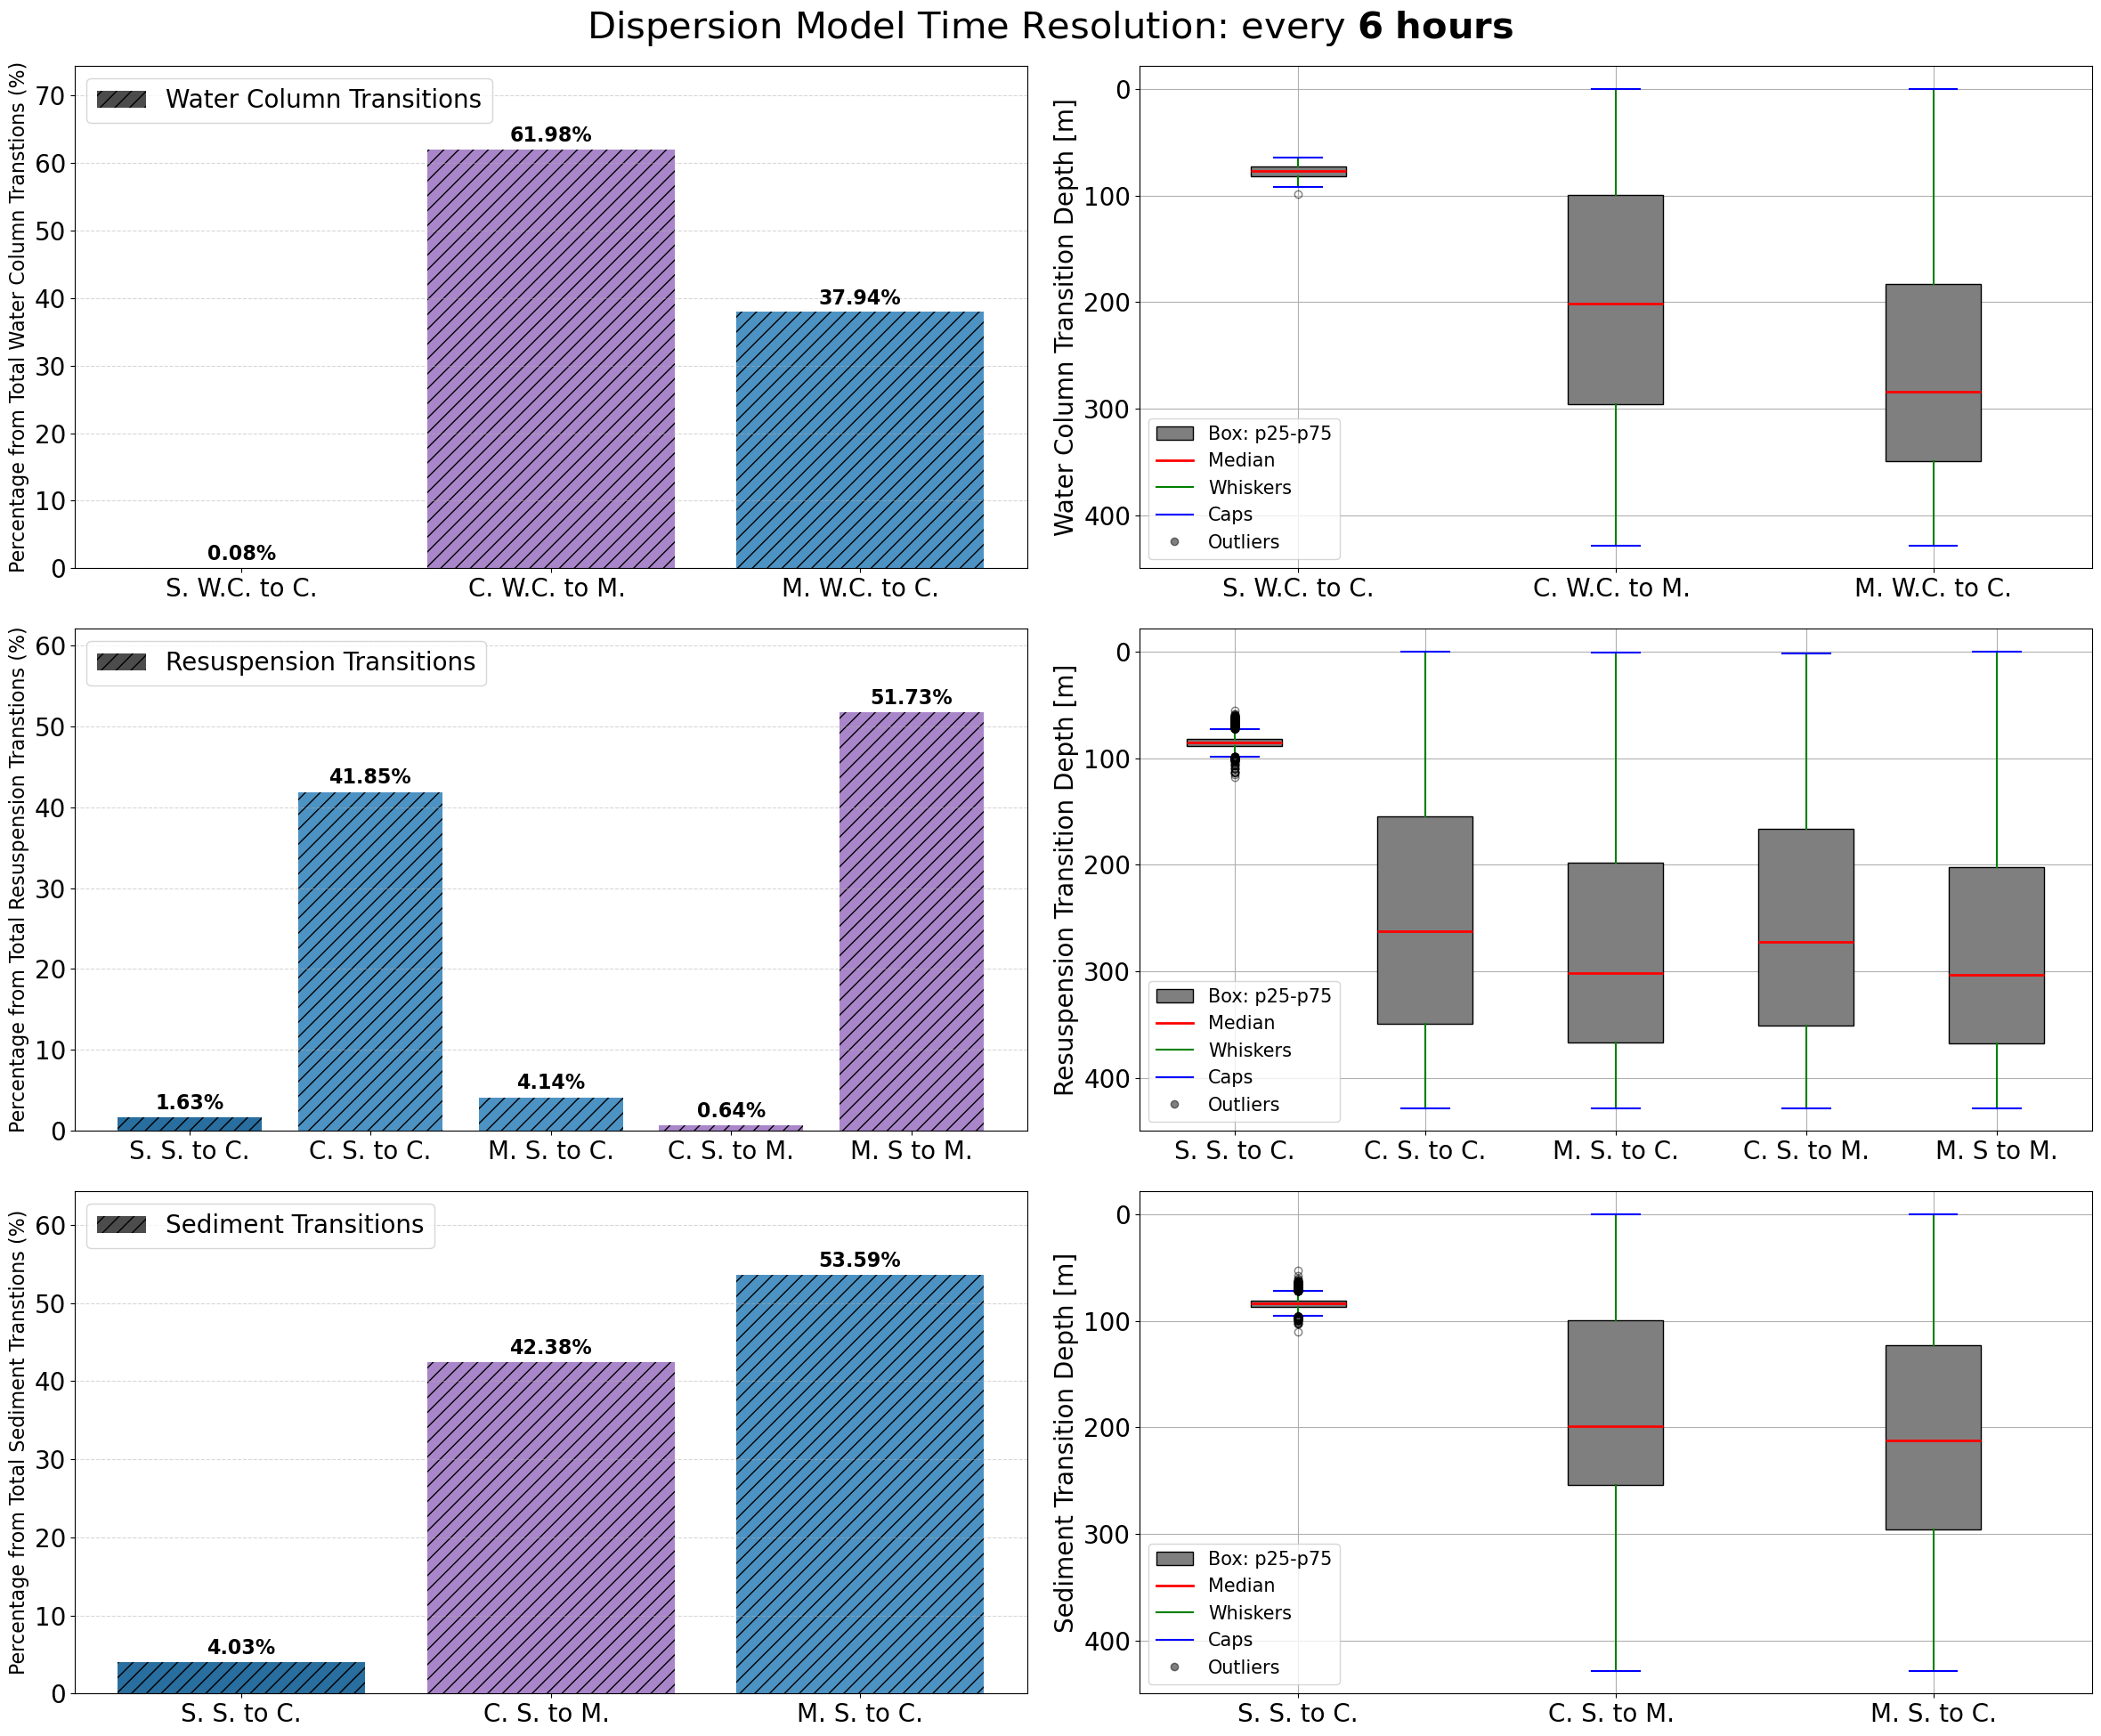

In [43]:
plt.rcParams.update({'font.size': 20})
#
fig, ax = plt.subplots(3,2,figsize=(24, 20), height_ratios=[1, 1, 1])
#
### IN THE WATER COLUMN TRANSITIONS
ax[0, 0].bar(labels_water[0], percentage_water[0], color = 'k', hatch = '//', alpha = .7, label = 'Water Column Transitions')
bars1_water = ax[0, 0].bar(labels_water, percentage_water, color = ['tab:blue', 'tab:purple', 'tab:blue'], hatch = '//', alpha = .8)
#
for bar, value in zip(bars1_water, percentage_water):
    ax[0,0].text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.5, 
        f'{value:.2f}%',
        ha='center', va='bottom', fontsize=16, fontweight='bold'
    )
    #
ax[0,0].set_ylabel('Percentage from Total Water Column Transtions (%)', fontsize=16)
ax[0,0].set_ylim(0, max(percentage_water) * 1.2) 
ax[0,0].grid(axis='y', linestyle='--', alpha=0.5)
ax[0,0].legend(loc = 'upper left')
######
ax[0,1].boxplot(depth_data_water, labels=labels_water, patch_artist=True,
                boxprops=dict(facecolor='tab:grey', color='k'),
                medianprops=dict(color='red', linewidth=2),
                whiskerprops=dict(color='green', linewidth=1.5),
                capprops=dict(color='blue', linewidth=1.5),
                flierprops=dict(marker='o', color='k', alpha=0.5))

ax[0,1].invert_yaxis()
ax[0,1].grid()
ax[0,1].set_ylabel('Water Column Transition Depth [m]')
#
### RESUSPENSION TRANSITIONS
ax[1, 0].bar(labels_res[0], per_res[0], color = 'k', hatch = '//', alpha = .7, label = 'Resuspension Transitions')
bars1_resuspension = ax[1, 0].bar(labels_res, per_res, color = ['tab:blue', 'tab:blue', 'tab:blue', 'tab:purple', 'tab:purple'], hatch = '//', alpha = .8)
#
for bar, value in zip(bars1_resuspension, per_res):
    ax[1,0].text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.5, 
        f'{value:.2f}%',
        ha='center', va='bottom', fontsize=16, fontweight='bold'
    )

ax[1,0].set_ylabel('Percentage from Total Resuspension Transtions (%)', fontsize=16)
ax[1,0].set_ylim(0, max(per_res) * 1.2) 
ax[1,0].grid(axis='y', linestyle='--', alpha=0.5)
ax[1,0].legend(loc = 'upper left')
######
ax[1,1].boxplot(depth_data, labels=labels_res, patch_artist=True,
                boxprops=dict(facecolor='tab:grey', color='k'),
                medianprops=dict(color='red', linewidth=2),
                whiskerprops=dict(color='green', linewidth=1.5),
                capprops=dict(color='blue', linewidth=1.5),
                flierprops=dict(marker='o', color='k', alpha=0.5))

ax[1,1].invert_yaxis()
ax[1,1].grid()
ax[1,1].set_ylabel('Resuspension Transition Depth [m]')
### IN THE SEDIMENT TRANSITIONS
ax[2, 0].bar(labels_sediment[0], percentage_sediment[0], color = 'k', hatch = '//', alpha = .7, label = 'Sediment Transitions')
bars1_sediment = ax[2, 0].bar(labels_sediment, percentage_sediment, color = ['tab:blue', 'tab:purple', 'tab:blue'], hatch = '//', alpha = .8)
#
for bar, value in zip(bars1_sediment, percentage_sediment):
    ax[2,0].text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.5, 
        f'{value:.2f}%',
        ha='center', va='bottom', fontsize=16, fontweight='bold'
    )

ax[2,0].set_ylabel('Percentage from Total Sediment Transtions (%)', fontsize=16)
ax[2,0].set_ylim(0, max(percentage_sediment) * 1.2) 
ax[2,0].grid(axis='y', linestyle='--', alpha=0.5)
ax[2,0].legend(loc = 'upper left')
######
ax[2,1].boxplot(depth_data_sediment, labels=labels_sediment, patch_artist=True,
                boxprops=dict(facecolor='tab:grey', color='k'),
                medianprops=dict(color='red', linewidth=2),
                whiskerprops=dict(color='green', linewidth=1.5),
                capprops=dict(color='blue', linewidth=1.5),
                flierprops=dict(marker='o', color='k', alpha=0.5))

ax[2,1].invert_yaxis()
ax[2,1].grid()
ax[2,1].set_ylabel('Sediment Transition Depth [m]')
# # # # # #
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [
    Patch(facecolor='tab:grey', edgecolor='k', label='Box: p25-p75'),
    Line2D([0], [0], color='red', lw=2, label='Median'),
    Line2D([0], [0], color='green', lw=1.5, label='Whiskers'),
    Line2D([0], [0], color='blue', lw=1.5, label='Caps'),
    Line2D([0], [0], marker='o', color='k', linestyle='None', alpha=0.5, label='Outliers')
]

# Add legend to each right-column subplot
for i in [0,1,2]:
    ax[i,1].legend(handles=legend_elements, loc='lower left', fontsize = 15)
plt.suptitle(r'Dispersion Model Time Resolution: every $\bf{6}$ $\bf{hours}$', fontsize = 30)
#
plt.tight_layout()
plt.show()